# Evaluating Ranking Permutations
J. Nathan Matias, February 2024

Given a ranking system that involves multiple evaluators per item, what is the impact of adjusting the ranking system in some way?

## Load Libraries

In [335]:
import csv, seaborn, random
from collections import Counter, defaultdict
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import copy, math

### Simulate Ratings

In [469]:
n_items = 250
n_raters = 25
ratings_per_item = 4
rating_scale = 9
rating_stdev = 2

max_ratings_per_rater = math.ceil(float(n_items*ratings_per_item) / float(n_raters))

def rater_dict():
    return {"rating_avg":float(random.randint(0,100))/100*rating_scale,
            "ratings_allocated":0}

raters = defaultdict(rater_dict)

for i in range(n_raters):
    raters[i] = rater_dict()

## items get ratings_per_item ratings in a dict 
## with the rater as the key
## and the rating as the value

def item_dict():
    return {}

items = defaultdict(item_dict)

for i in range(n_items):
    counter = 0
    
    item = items[i]
    
    while len(item.keys()) < ratings_per_item:
        
        rater_index = random.choice([x for x in raters.keys() if x not in item.keys() and 
                                     (raters[x]['ratings_allocated']>max_ratings_per_rater)!=True])
        rater_object = raters[rater_index]
        
        counter += 1
            
        if(counter>10000): 
             break
        
        if(rater_object["ratings_allocated"]>= max_ratings_per_rater):
            continue
        
        rating = int(np.random.normal(float(rating_scale)/2, rating_stdev))
        
        items[i][rater_index] = rating
        rater_object['ratings_allocated'] += 1
        

#### Plot Simulated Ratings

In [470]:
item_rows = []

for k, r in items.items():
    key = "i " + str(k)
    for v in r.values():
        item_rows.append({"item":key, "rating":v})

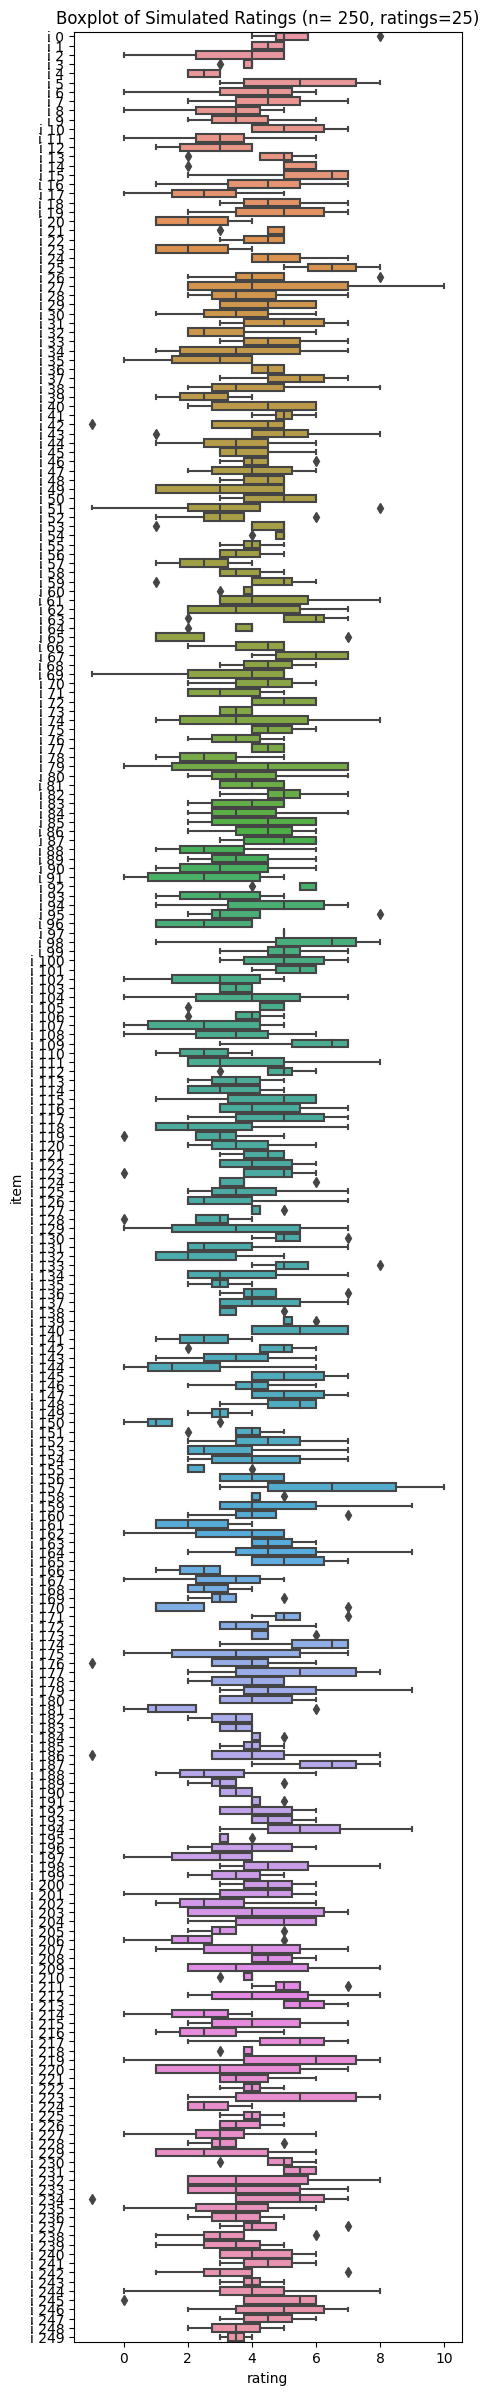

In [471]:
plt.figure(figsize=(5,30))
sns.boxplot(data=pd.DataFrame(item_rows), x="rating", y="item")
plt.title("Boxplot of Simulated Ratings (n= {0}, ratings={1})".format(n_items, n_raters))
plt.show()

## Compute Results and Permutations
* Compute the following for the full set of ratings:
    * avg rating
    * rank position
    * whether it occurs in the top N
* For a given number of permutations where items get fewer ratings, compute the same
    

### Compute Results

In [472]:
min_selection_num = 20

In [473]:
## compute a ranked list of items
## where min_selection_num is the
## minimum number of items to include
## in the top list. The cutoff is
## all items with the same ranking
## as 

def compute_ranking(rated_items, min_selection_num, permutation_number = 1):
    ranking_list = []
    item_keys = list(rated_items.keys())
    random.shuffle(item_keys)
    for k in item_keys:
        item = rated_items[k]
        key = "i " + str(k)
        ranking = {"item": key, "mean_rating": np.mean([x for x in item.values()])}
        ranking_list.append(ranking)
    ranking_list = sorted(ranking_list, key = lambda x: x['mean_rating'], reverse=True)
    
    if len(ranking_list) < min_selection_num:
        print("min_selection_num is greater than available items. Including all items.")
        lowest_included_rating = ranking_list[-1]
    else:
        lowest_included_rating = ranking_list[min_selection_num]["mean_rating"]

    i = 0
    for row in ranking_list:
        row['ranking'] = i
        i+=1
        if(row['mean_rating']>=lowest_included_rating):
            row['selected'] = True
        else:
            row['selected'] = False
        
        row['permutation_number'] = permutation_number
    
    print("min_selection_num: {0}. Selected: {1}".format(min_selection_num,
                                                         len([x for x in ranking_list if x['selected']])))
    
    ranking_metadata = {"min_selection_num": min_selection_num,
                        "actual_selection_num": len([x for x in ranking_list if x['selected']]),
                        "permutation_number": permutation_number}
    return ranking_metadata, ranking_list

In [474]:
original_ranking_metadata, original_ranking = compute_ranking(items, min_selection_num)

min_selection_num: 20. Selected: 30


### Conduct a randomly sampled permutation

In [475]:
list(items[200].items())

[(13, 4), (12, 6), (7, 3), (1, 5)]

In [476]:
## this method randomly samples from ratings
## to create a subset of the data with only
## the specified ratings_per_item
def create_randomly_sampled_permutation(rated_items, rating_count):
    if rating_count >ratings_per_item:
        print ("Specified rating count greater or equal to available ratings. Returning full list.")
        return rated_items
    
    working_items = copy.deepcopy(rated_items)
    
    for k, ratings in working_items.items():
        rating_list = list(ratings.items())
        
        ## sample without replacement
        try:
            rating_list_subset = random.sample(rating_list, rating_count)
        except:
            print("ERROR: rating list: {0}, rating_count: {1}".format(rating_list, rating_count))
            return None
        new_ratings = {}
        for row in rating_list_subset:
            new_ratings[row[0]] = row[1]
        
        working_items[k] = new_ratings
    
    return working_items

### Create a set of randomly sampled permutations

In [477]:
permutation_count = 100
ratings_to_simulate = 2

full_rankings = copy.deepcopy(original_ranking)
full_ranking_metadata = [original_ranking_metadata]

for i in range(permutation_count):
    permutation_items = create_randomly_sampled_permutation(items, ratings_to_simulate)
    ranking_metadata, ranking = compute_ranking(permutation_items, min_selection_num, i+2)
    full_rankings += ranking
    full_ranking_metadata.append(ranking_metadata)

min_selection_num: 20. Selected: 27
min_selection_num: 20. Selected: 25
min_selection_num: 20. Selected: 21
min_selection_num: 20. Selected: 34
min_selection_num: 20. Selected: 22
min_selection_num: 20. Selected: 27
min_selection_num: 20. Selected: 27
min_selection_num: 20. Selected: 22
min_selection_num: 20. Selected: 29
min_selection_num: 20. Selected: 23
min_selection_num: 20. Selected: 23
min_selection_num: 20. Selected: 21
min_selection_num: 20. Selected: 22
min_selection_num: 20. Selected: 35
min_selection_num: 20. Selected: 36
min_selection_num: 20. Selected: 36
min_selection_num: 20. Selected: 26
min_selection_num: 20. Selected: 40
min_selection_num: 20. Selected: 24
min_selection_num: 20. Selected: 30
min_selection_num: 20. Selected: 40
min_selection_num: 20. Selected: 42
min_selection_num: 20. Selected: 24
min_selection_num: 20. Selected: 33
min_selection_num: 20. Selected: 23
min_selection_num: 20. Selected: 23
min_selection_num: 20. Selected: 23
min_selection_num: 20. Selec

In [478]:
full_ranking_metadata[0]

{'min_selection_num': 20, 'actual_selection_num': 30, 'permutation_number': 1}

## Compute Item-Level Variation in Ranking Position

In [479]:
full_rankings[0]

{'item': 'i 157',
 'mean_rating': 6.5,
 'ranking': 0,
 'selected': True,
 'permutation_number': 1}

In [480]:
## for each ranked item
## create an aggregated row that
## can be used to compute the impact
## oc changes in ratings
def generate_aggregate_item_rows(ranking_rows, ranking_metadata):
    aggregate_rows = []
    item_keys = list(set([x['item'] for x in ranking_rows]))
    
    ## for each item in the dataset
    for item_key in item_keys:
        item_rankings = [x for x in ranking_rows if x['item']==item_key]
        original_ranking = [x for x in item_rankings if x['permutation_number']==1][0]
        sim_rankings = [x for x in item_rankings if x['permutation_number']!=1]
        
        row = {
            "item": item_key,
            "orig_rating": original_ranking['mean_rating'],
            "orig_ranking": original_ranking['ranking'],
            "orig_selected": int(original_ranking['selected']),
            "orig_num_ratings": ratings_per_item,
            "orig_num_selected": ranking_metadata[0]['actual_selection_num'],
            "sim_num_iterations": len(sim_rankings),
            "sim_mean_rating": np.mean([x['mean_rating'] for x in sim_rankings]),
            "sim_mean_ranking": np.mean([x['ranking'] for x in sim_rankings]),
            "sim_selected_prop": np.mean([float(x['selected']) for x in sim_rankings]),
            "sim_max_higher_diff": original_ranking['ranking'] - min([x['ranking'] for x in sim_rankings]),
            "sim_max_lower_diff": max([x['ranking'] for x in sim_rankings]) - original_ranking['ranking'],
            "sim_num_ratings": ratings_to_simulate,
            "sim_mean_num_selected": np.mean([x['actual_selection_num'] for x in ranking_metadata[1:]])}
        
        aggregate_rows.append(row)
        
    return(aggregate_rows)
        
        
        
        

In [481]:
aggregate_item_rows = generate_aggregate_item_rows(full_rankings, full_ranking_metadata)
item_df = pd.DataFrame(aggregate_item_rows)

In [482]:
item_df

,item,orig_rating,orig_ranking,orig_selected,orig_num_ratings,orig_num_selected,sim_num_iterations,sim_mean_rating,sim_mean_ranking,sim_selected_prop,sim_max_higher_diff,sim_max_lower_diff,sim_num_ratings,sim_mean_num_selected
0,i 180,4.25,95,0,4,30,100,4.205,110.02,0.03,79,111,2,27.26
1,i 194,5.75,5,1,4,30,100,5.830,38.57,0.56,5,149,2,27.26
2,i 173,4.50,78,0,4,30,100,4.540,86.64,0.00,41,66,2,27.26
3,i 248,3.50,164,0,4,30,100,3.500,159.34,0.00,25,21,2,27.26
4,i 197,2.50,234,0,4,30,100,2.430,206.69,0.00,130,15,2,27.26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,i 25,6.50,1,1,4,30,100,6.480,11.81,0.88,1,43,2,27.26
246,i 5,5.50,15,1,4,30,100,5.760,43.71,0.44,15,166,2,27.26
247,i 231,5.50,11,1,4,30,100,5.445,35.38,0.25,3,59,2,27.26
248,i 42,3.25,202,0,4,30,100,3.370,149.19,0.00,160,41,2,27.26
